In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from prophet import Prophet

# Load the dataset
df = pd.read_csv("network_traffic_simulation.csv")

# Convert 'datetime' to datetime type
df['datetime'] = pd.to_datetime(df['datetime'])

# Basic info about the dataset
print("\nDataset Info:")
print(df.info())

# Summary statistics
print("\nSummary Statistics:")
df.describe()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   datetime          15120 non-null  datetime64[ns]
 1   offer_type        15120 non-null  object        
 2   active_users      15120 non-null  int64         
 3   packets_received  15120 non-null  int64         
 4   packets_sent      15120 non-null  int64         
 5   throughput_Mbps   15120 non-null  float64       
 6   latency_ms        15120 non-null  float64       
 7   jitter_ms         15120 non-null  float64       
 8   packet_loss_pct   15120 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(3), object(1)
memory usage: 1.0+ MB
None

Summary Statistics:


datetime  active_users  packets_received  packets_sent  \
count                15120  1.512000e+04      1.512000e+04  1.512000e+04   
mean   2025-02-14 23:30:00  2.170408e+05      6.503409e+07  4.878111e+07   
min    2025-01-01 00:00:00  0.000000e+00      0.000000e+00  0.000000e+00   
25%    2025-01-23 11:45:00  2.250000e+04      6.536656e+06  4.913449e+06   
50%    2025-02-14 23:30:00  7.030550e+04      2.095782e+07  1.565710e+07   
75%    2025-03-09 11:15:00  2.651652e+05      7.892440e+07  5.882658e+07   
max    2025-03-31 23:00:00  1.817880e+06      7.068658e+08  4.470057e+08   
std                    NaN  3.116313e+05      9.608074e+07  7.189254e+07   

       throughput_Mbps    latency_ms     jitter_ms  packet_loss_pct  
count     15120.000000  15120.000000  15120.000000     15120.000000  
mean        400.305831     29.958888      7.473669         1.989553  
min          32.403307      3.671981     -1.372125         0.000000  
25%          87.735607     24.865290      5.135939         1.215778  
50%         336.190370     29.032128      6.897613         1.576320  
75%         663.425130     34.312837      9.239661         2.477846  
max        1304.953664     60.305833     20.391444         5.000000  
std         340.615746      7.364797      3.328692         1.115530



### **1. `datetime`**


* **Meaning:** The **timestamp** of the observation.
* Since your data is **hourly**, each row represents the metrics for that specific hour.
* **Use:** Essential for **time series analysis**, forecasting traffic trends, or detecting daily/weekly patterns.

---

### **2. `offer_type`**

* **Type:** `object` (categorical)
* **Meaning:** The **type of internet offer/package** (e.g., 60Mbps, 100Mbps).
* **Use:** Helps to analyze traffic per offer or plan. Some offers may have more active users or higher throughput.

---

### **3. `active_users`**


* **Meaning:** The **number of users actively using the internet** during that hour for the given offer.
* **Use:** Measures **network load** and helps forecast demand.

---

### **4. `packets_received`**


* **Meaning:** The **number of data packets received** by the network/server during that hour.
* **Use:** Helps monitor **incoming traffic volume**. Useful for detecting congestion or DDoS attacks.

---

### **5. `packets_sent`**


* **Meaning:** The **number of data packets sent** from the network/server to users during that hour.
* **Use:** Monitors **outgoing traffic**. Combined with packets received, it indicates **overall network utilization**.

---

### **6. `throughput_Mbps`**


* **Meaning:** The **rate of data transfer** over the network in **megabits per second**.
* **Use:** Measures **network capacity utilization**. Higher throughput means more data is being transmitted successfully.

**Example:** If throughput = 50 Mbps → 50 megabits of data were transferred per second.

---

### **7. `latency_ms`**


* **Meaning:** The **round-trip time** it takes for a data packet to travel from source to destination (in milliseconds).
* **Use:** Important for **real-time applications** like video calls or gaming.
* Lower latency is better. High latency may indicate network congestion or routing issues.

---

### **8. `jitter_ms`**


* **Meaning:** The **variation in latency** between packets.
* **Use:** Measures **stability of the network**.
* High jitter can cause **lag in VoIP, streaming, or online gaming**, even if average latency is low.

---

### **9. `packet_loss_pct`**


* **Meaning:** The **percentage of packets lost** during transmission.
* **Use:** Measures **network reliability**.
* Lower packet loss is better; high packet loss indicates congestion, faulty hardware, or poor connection quality.

**Example:** `packet_loss_pct = 2%` → 2 out of 100 packets were lost.

---




In [4]:
df.head()

datetime offer_type  active_users  packets_received  packets_sent  \
0 2025-01-01     60Mbps        131241          45461723      31471430   
1 2025-01-01    120Mbps        107798          25479673      19135295   
2 2025-01-01    240Mbps             0                 0             0   
3 2025-01-01    480Mbps          7771           2474930       1219794   
4 2025-01-01    600Mbps           519            174823        112115   

   throughput_Mbps  latency_ms  jitter_ms  packet_loss_pct  
0        41.585207   40.495900  12.865059         4.807097  
1        81.183154   36.046134   9.650591         2.092683  
2       161.252550   24.626546   4.258726         2.273028  
3       337.620677   19.959592   3.739680         1.529376  
4       411.249188   26.599181   3.717911         1.580097

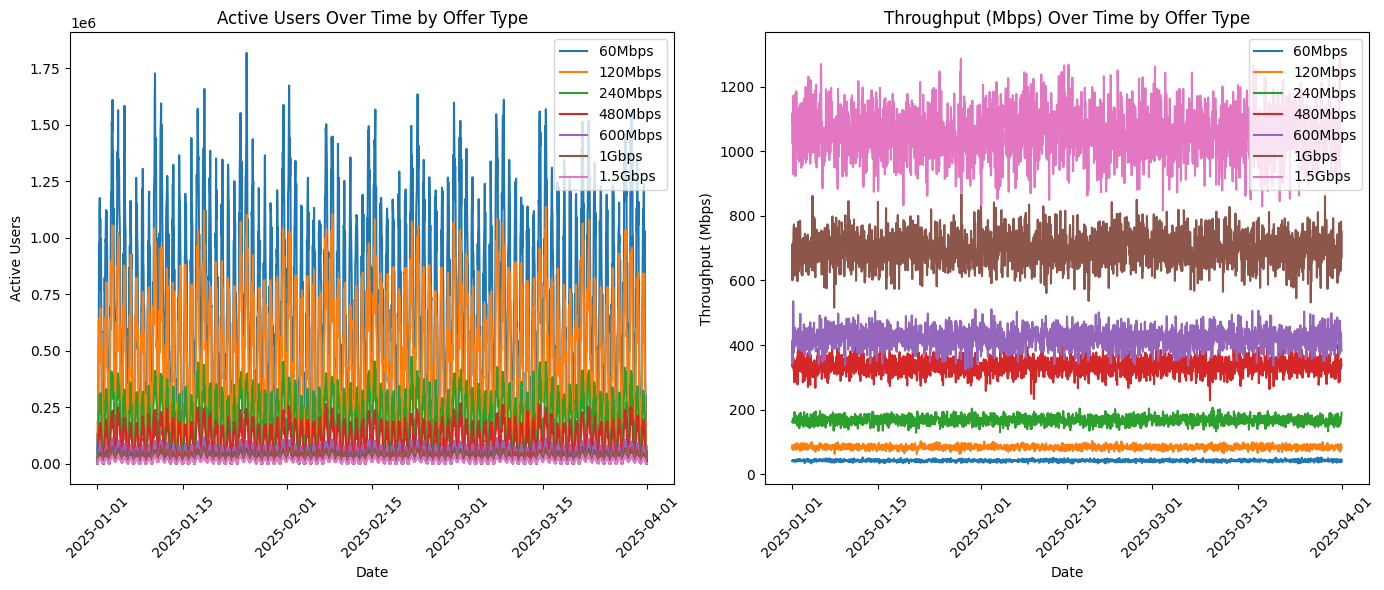

In [5]:
# Set datetime as index for time series analysis
df.set_index('datetime', inplace=True)

# Plot active users and throughput by offer type
plt.figure(figsize=(14, 6))

# Active users
plt.subplot(1, 2, 1)
for offer in df['offer_type'].unique():
    df_offer = df[df['offer_type'] == offer]
    plt.plot(df_offer.index, df_offer['active_users'], label=offer)
plt.title('Active Users Over Time by Offer Type')
plt.xlabel('Date')
plt.ylabel('Active Users')
plt.legend()
plt.xticks(rotation=45)

# Throughput
plt.subplot(1, 2, 2)
for offer in df['offer_type'].unique():
    df_offer = df[df['offer_type'] == offer]
    plt.plot(df_offer.index, df_offer['throughput_Mbps'], label=offer)
plt.title('Throughput (Mbps) Over Time by Offer Type')
plt.xlabel('Date')
plt.ylabel('Throughput (Mbps)')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

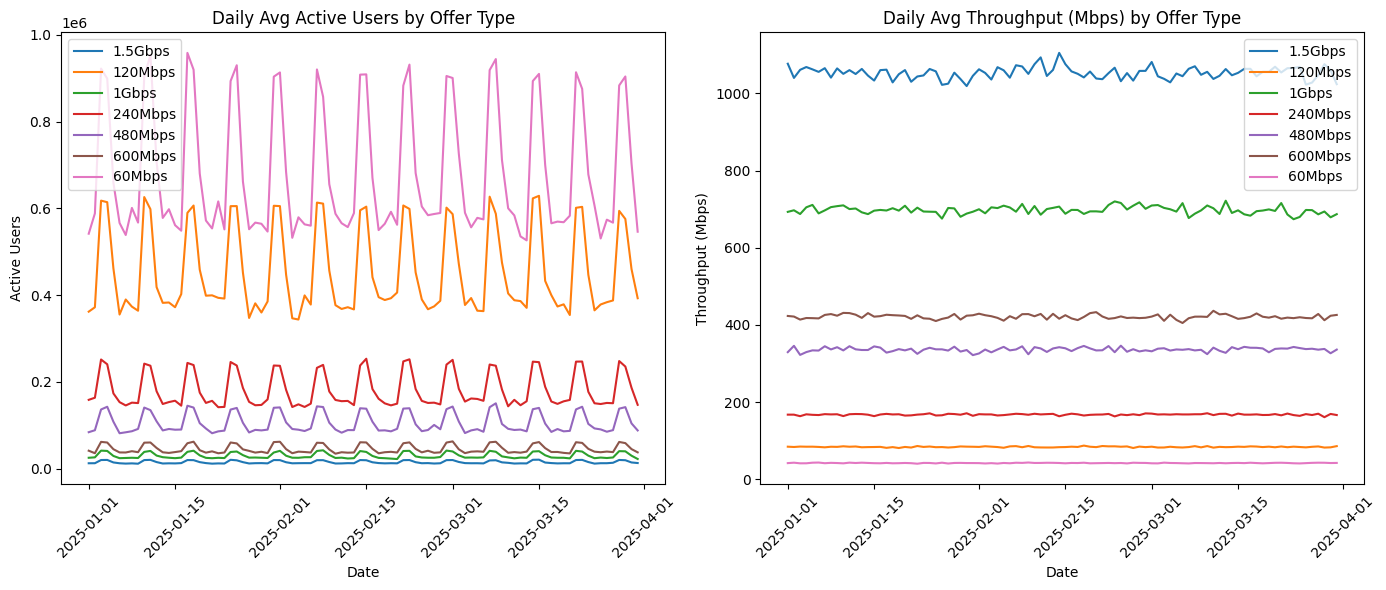

In [6]:
# Aggregate to daily level
df_daily = df.groupby([pd.Grouper(freq='D'), 'offer_type']).agg({
    'active_users': 'mean',
    'throughput_Mbps': 'mean'
}).reset_index()

# Plot daily aggregated trends
plt.figure(figsize=(14, 6))

# Active users
plt.subplot(1, 2, 1)
for offer in df_daily['offer_type'].unique():
    df_offer = df_daily[df_daily['offer_type'] == offer]
    plt.plot(df_offer['datetime'], df_offer['active_users'], label=offer)
plt.title('Daily Avg Active Users by Offer Type')
plt.xlabel('Date')
plt.ylabel('Active Users')
plt.legend()
plt.xticks(rotation=45)

# Throughput
plt.subplot(1, 2, 2)
for offer in df_daily['offer_type'].unique():
    df_offer = df_daily[df_daily['offer_type'] == offer]
    plt.plot(df_offer['datetime'], df_offer['throughput_Mbps'], label=offer)
plt.title('Daily Avg Throughput (Mbps) by Offer Type')
plt.xlabel('Date')
plt.ylabel('Throughput (Mbps)')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

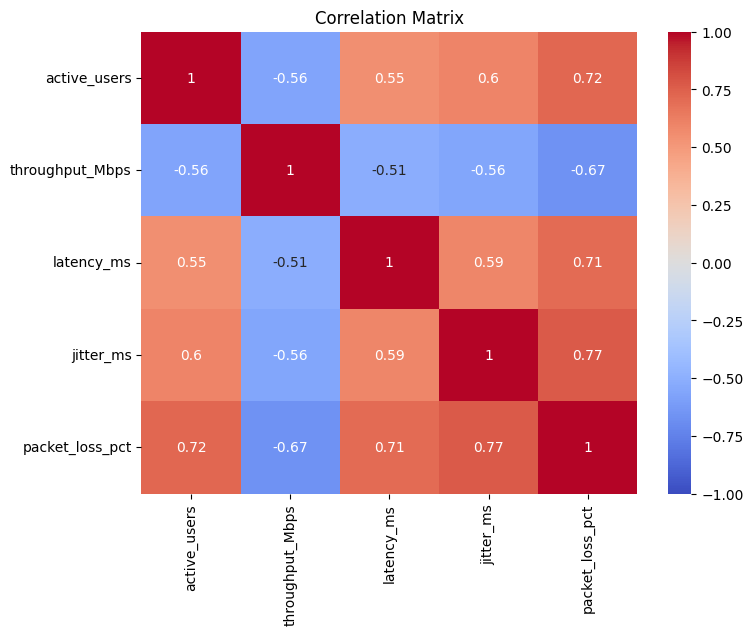

In [7]:
# Correlation matrix
corr = df[['active_users', 'throughput_Mbps', 'latency_ms', 'jitter_ms', 'packet_loss_pct']].corr()

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [8]:
# Function to prepare data and forecast
from prophet.plot import plot_plotly
import plotly.offline as py
def forecast_metric(df, offer, metric, periods=1*24):  # Forecast 7 days
    # Filter by offer type
    df_offer = df[df['offer_type'] == offer][[metric]].reset_index()
    df_offer.columns = ['ds', 'y']
    
    # Initialize Prophet model
    model = Prophet(
        yearly_seasonality=False,
        weekly_seasonality=True,
        daily_seasonality=True
    )
    
    # Fit model
    model.fit(df_offer)
    
    # Create future dataframe
    future = model.make_future_dataframe(periods=periods, freq='h')
    
    # Predict
    forecast = model.predict(future)
    
    # Plot forecast
    fig = plot_plotly(model, forecast)  # interactive plot
    py.iplot(fig)  # only shows predictions with confidence intervals
    
    return forecast

# Forecast for each offer type
for offer in df['offer_type'].unique():
    print(f"\nForecasting for {offer}")
    # Forecast active users
    forecast_users = forecast_metric(df, offer, 'active_users')
    # Forecast throughput
    # forecast_throughput = forecast_metric(df, offer, 'throughput_Mbps')


Forecasting for 60Mbps


17:49:38 - cmdstanpy - INFO - Chain [1] start processing
17:49:39 - cmdstanpy - INFO - Chain [1] done processing



Forecasting for 120Mbps


17:49:43 - cmdstanpy - INFO - Chain [1] start processing
17:49:43 - cmdstanpy - INFO - Chain [1] done processing



Forecasting for 240Mbps


17:49:44 - cmdstanpy - INFO - Chain [1] start processing
17:49:44 - cmdstanpy - INFO - Chain [1] done processing



Forecasting for 480Mbps


17:49:45 - cmdstanpy - INFO - Chain [1] start processing
17:49:45 - cmdstanpy - INFO - Chain [1] done processing



Forecasting for 600Mbps


17:49:46 - cmdstanpy - INFO - Chain [1] start processing
17:49:46 - cmdstanpy - INFO - Chain [1] done processing


17:49:47 - cmdstanpy - INFO - Chain [1] start processing



Forecasting for 1Gbps


17:49:47 - cmdstanpy - INFO - Chain [1] done processing



Forecasting for 1.5Gbps


17:49:48 - cmdstanpy - INFO - Chain [1] start processing
17:49:48 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
# # Function to forecast using both historical average and rolling average
# df = df.reset_index()  # this moves the index into a column named 'index'
# df = df.rename(columns={'index': 'datetime'})  # rename it to 'datetime'

# def forecast_average(df, offer, metric='active_users', forecast_hours=7*24, rolling_window=24):
#     # Filter data for the offer
#     df_offer = df[df['offer_type'] == offer].copy()
    
#     # Calculate historical average
#     avg_value = df_offer[metric].mean()
    
#     # Calculate rolling average
#     df_offer['rolling_avg'] = df_offer[metric].rolling(window=rolling_window, min_periods=1).mean()
#     last_rolling_avg = df_offer['rolling_avg'].iloc[-1]
    
#     # Create future forecast dates
#     last_date = df_offer['datetime'].max()
#     forecast_dates = pd.date_range(start=last_date + pd.Timedelta(hours=1), periods=forecast_hours, freq='H')
    
#     # Create forecast DataFrames
#     forecast_avg = pd.DataFrame({'datetime': forecast_dates, metric: avg_value})
#     forecast_rolling = pd.DataFrame({'datetime': forecast_dates, metric: last_rolling_avg})
    
#     # Plot historical and forecasts
#     plt.figure(figsize=(14,6))
#     plt.plot(df_offer['datetime'], df_offer[metric], label='Historical', color='blue', alpha=0.7)
#     plt.plot(df_offer['datetime'], df_offer['rolling_avg'], label=f'Rolling Average ({rolling_window}-hour)', color='green', linestyle='-.')
#     plt.plot(forecast_avg['datetime'], forecast_avg[metric], label='Forecast (Average)', color='red', linestyle='--')
#     plt.plot(forecast_rolling['datetime'], forecast_rolling[metric], label=f'Forecast (Rolling Avg {rolling_window}-hour)', color='orange', linestyle='--')
    
#     plt.title(f'Forecast for {metric} - {offer}')
#     plt.xlabel('Date')
#     plt.ylabel(metric)
#     plt.legend()
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.show()

# # Apply the forecast function for all offer types
# for offer in df['offer_type'].unique():
#     forecast_average(df, offer, metric='active_users', forecast_hours=7*24, rolling_window=24)

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

17:51:37 - cmdstanpy - INFO - Chain [1] start processing
17:51:37 - cmdstanpy - INFO - Chain [1] done processing


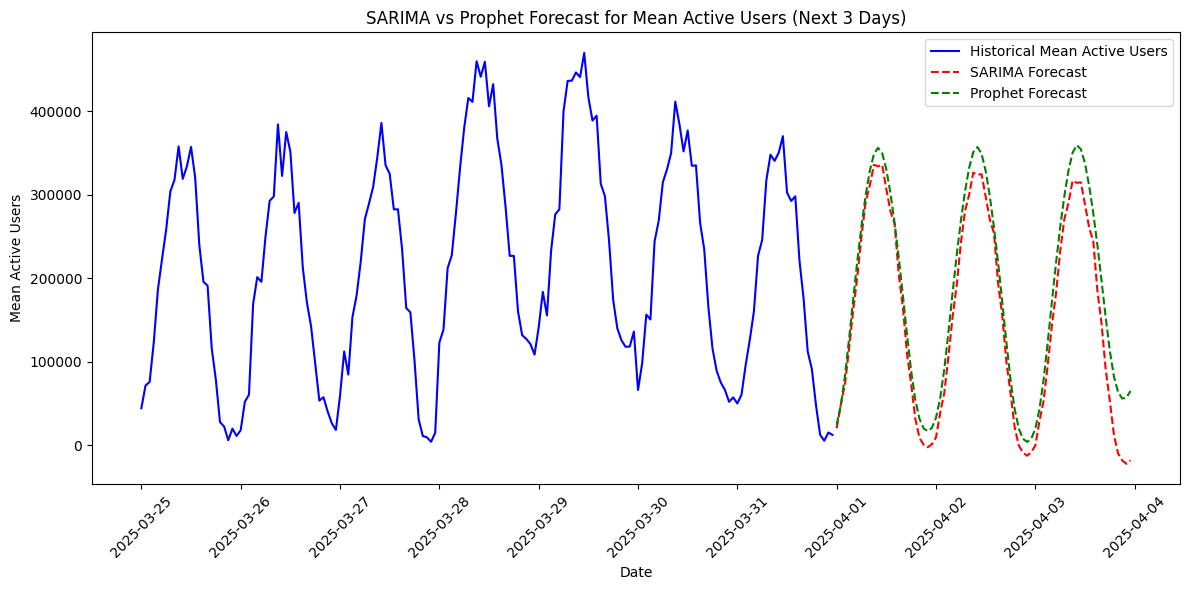


SARIMA Model Summary for Mean Active Users:
                                     SARIMAX Results                                      
Dep. Variable:                       active_users   No. Observations:                 2160
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood              -24596.973
Date:                            Wed, 17 Sep 2025   AIC                          49203.946
Time:                                    17:51:39   BIC                          49232.215
Sample:                                01-01-2025   HQIC                         49214.298
                                     - 03-31-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0829      0.068     -1.219      0.223      -0.216   

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Aggregate to compute mean active users across all offer types
df_mean_users = df.groupby(df.index)['active_users'].mean()

# --- SARIMA Forecasting ---
# Define SARIMA model: (1,1,1)(1,1,1,24) for daily seasonality
sarima_model = SARIMAX(df_mean_users, 
                       order=(1, 1, 1), 
                       seasonal_order=(1, 1, 1, 24),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

# Fit SARIMA model
sarima_fit = sarima_model.fit(disp=False)

# Forecast for next 3 days (72 hours)
forecast_periods = 72
sarima_forecast = sarima_fit.forecast(steps=forecast_periods)

# Create SARIMA forecast index
last_date = df_mean_users.index[-1]
sarima_forecast_index = pd.date_range(start=last_date + pd.Timedelta(hours=1), 
                                     periods=forecast_periods, freq='h')

# Create SARIMA forecast DataFrame
sarima_forecast_df = pd.DataFrame({'mean_active_users': sarima_forecast}, 
                                 index=sarima_forecast_index)

# --- Prophet Forecasting ---
# Prepare data for Prophet
prophet_df = df_mean_users.reset_index().rename(columns={'datetime': 'ds', 'active_users': 'y'})

# Initialize Prophet model
prophet_model = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=True
)

# Fit Prophet model
prophet_model.fit(prophet_df)

# Create future dataframe for Prophet
future = prophet_model.make_future_dataframe(periods=forecast_periods, freq='h')
prophet_forecast = prophet_model.predict(future)

# Extract forecast for the next 3 days
prophet_forecast_df = prophet_forecast[['ds', 'yhat']].tail(forecast_periods).set_index('ds')


# --- Plot Historical and Forecasts ---
plt.figure(figsize=(12, 6))
# Historical data (last 7 days)
plt.plot(df_mean_users.index[-24*7:], df_mean_users[-24*7:], 
         label='Historical Mean Active Users', color='blue')
# SARIMA forecast
plt.plot(sarima_forecast_df.index, sarima_forecast_df['mean_active_users'], 
         label='SARIMA Forecast', linestyle='--', color='red')
# Prophet forecast
plt.plot(prophet_forecast_df.index, prophet_forecast_df['yhat'], 
         label='Prophet Forecast', linestyle='--', color='green')

plt.title('SARIMA vs Prophet Forecast for Mean Active Users (Next 3 Days)')
plt.xlabel('Date')
plt.ylabel('Mean Active Users')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('sarima_prophet_forecast_mean_users.png')
plt.show()

# Print SARIMA model summary
print("\nSARIMA Model Summary for Mean Active Users:")
print(sarima_fit.summary())

> vvv